In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
out_dir = '../../results/07_marchphages/01_mac_clustering'

In [3]:
os.makedirs(out_dir, exist_ok=True)

In [4]:
adata = sc.read_h5ad('../../results/03_integrate_scrna/integrated.h5ad')

In [5]:
# update dataset name
adata.obs['data'] = adata.obs['data'].str.replace(r'cell_2022', 'Gur2022', regex=True)
adata.obs['data'] = adata.obs['data'].str.replace(r'nc_2021', 'Tabib2021', regex=True)

In [6]:
adata

AnnData object with n_obs × n_vars = 95898 × 15275
    obs: 'patient_id', 'condition', 'cell_type', 'data', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'condition_colors', 'data_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
adata.raw = adata.copy()

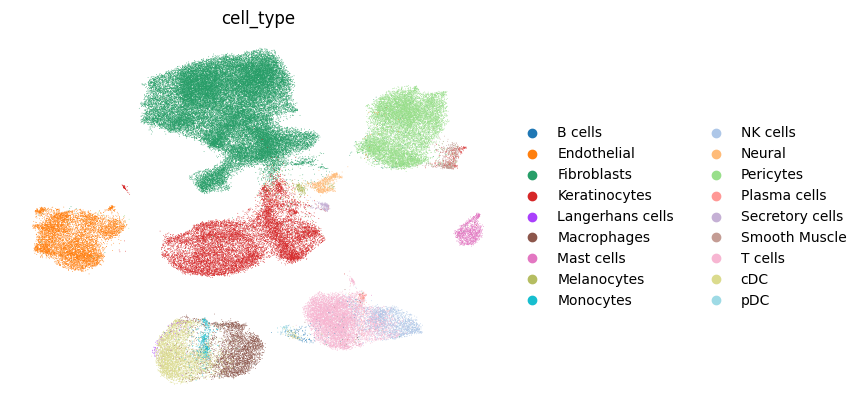

In [8]:
sc.pl.umap(adata, color=['cell_type'], frameon=False)

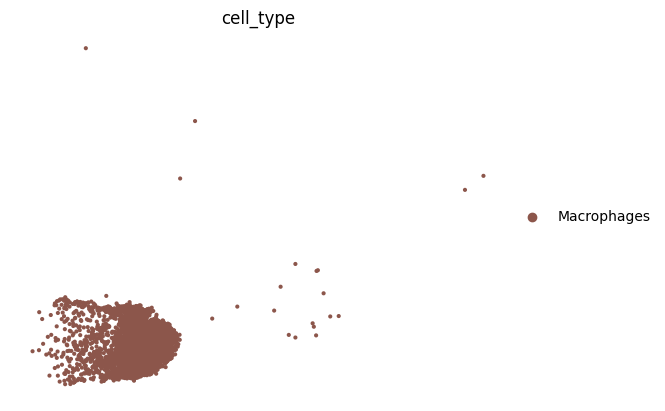

In [9]:
# subset all fibroblast cells
adata = adata[adata.obs['cell_type'] == "Macrophages", :].copy()
sc.pl.umap(adata, color=['cell_type'], frameon=False)

In [10]:
adata

AnnData object with n_obs × n_vars = 3380 × 15275
    obs: 'patient_id', 'condition', 'cell_type', 'data', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'condition_colors', 'data_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [11]:
# remove patients with two few cells
df_count = adata.obs['patient_id'].value_counts()

In [12]:
sel_patients = df_count[df_count > 50].index.tolist()
adata = adata[adata.obs['patient_id'].isin(sel_patients)].copy()

In [13]:
sel_patients

['GSM4115889',
 'pt01033',
 'pt03006',
 'GSM4115875',
 'pt03013',
 'pt03020',
 'pt01034',
 'pt03014',
 'pt01020',
 'pt03026',
 'pt01031',
 'GSM4115881',
 'pt01022',
 'GSM4115887',
 'GSM4115871',
 'pt01026',
 'pt01021',
 'pt01035',
 'GSM4115872',
 'pt03015',
 'pt01027']

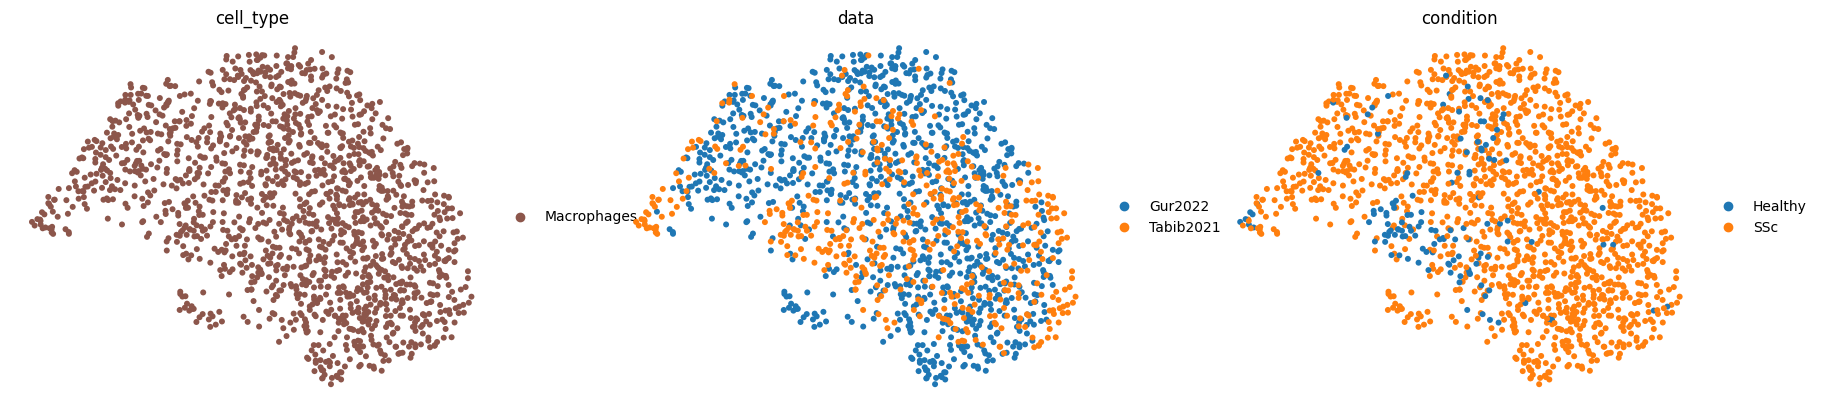

In [14]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'data', 'condition'], frameon=False)

In [25]:
sc.tl.leiden(adata, key_added="leiden", resolution=0.3)

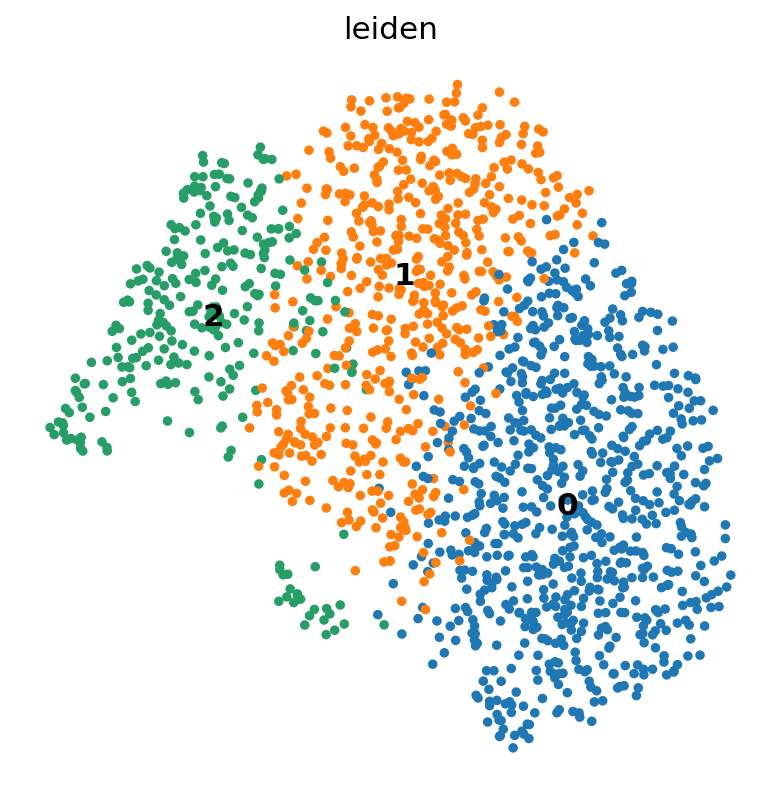

In [26]:
sc.set_figure_params(figsize=(6, 6))

sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data')

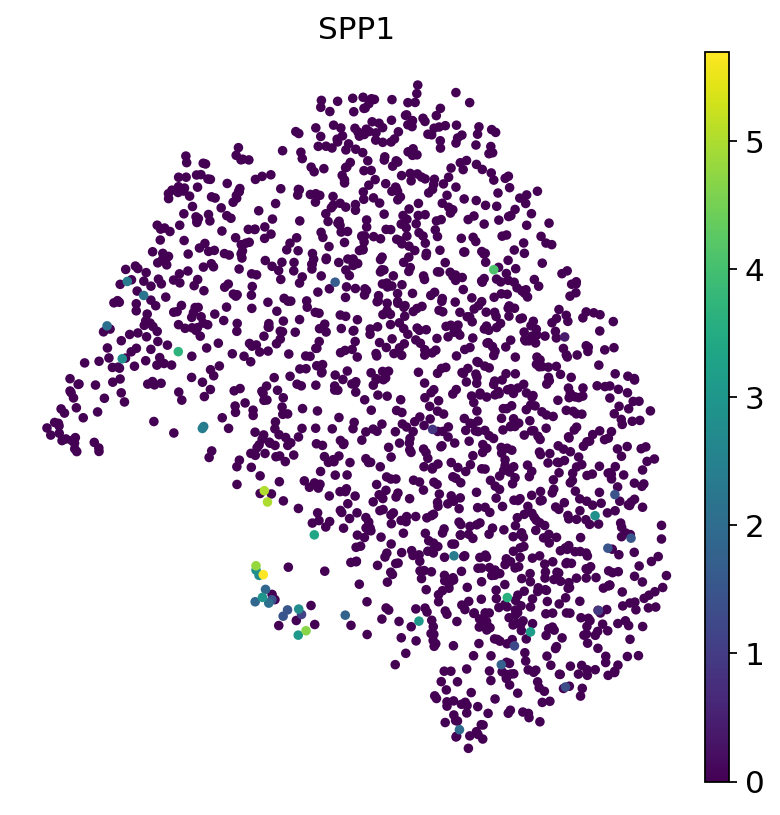

In [27]:
sc.pl.umap(adata, color=['SPP1'], frameon=False)

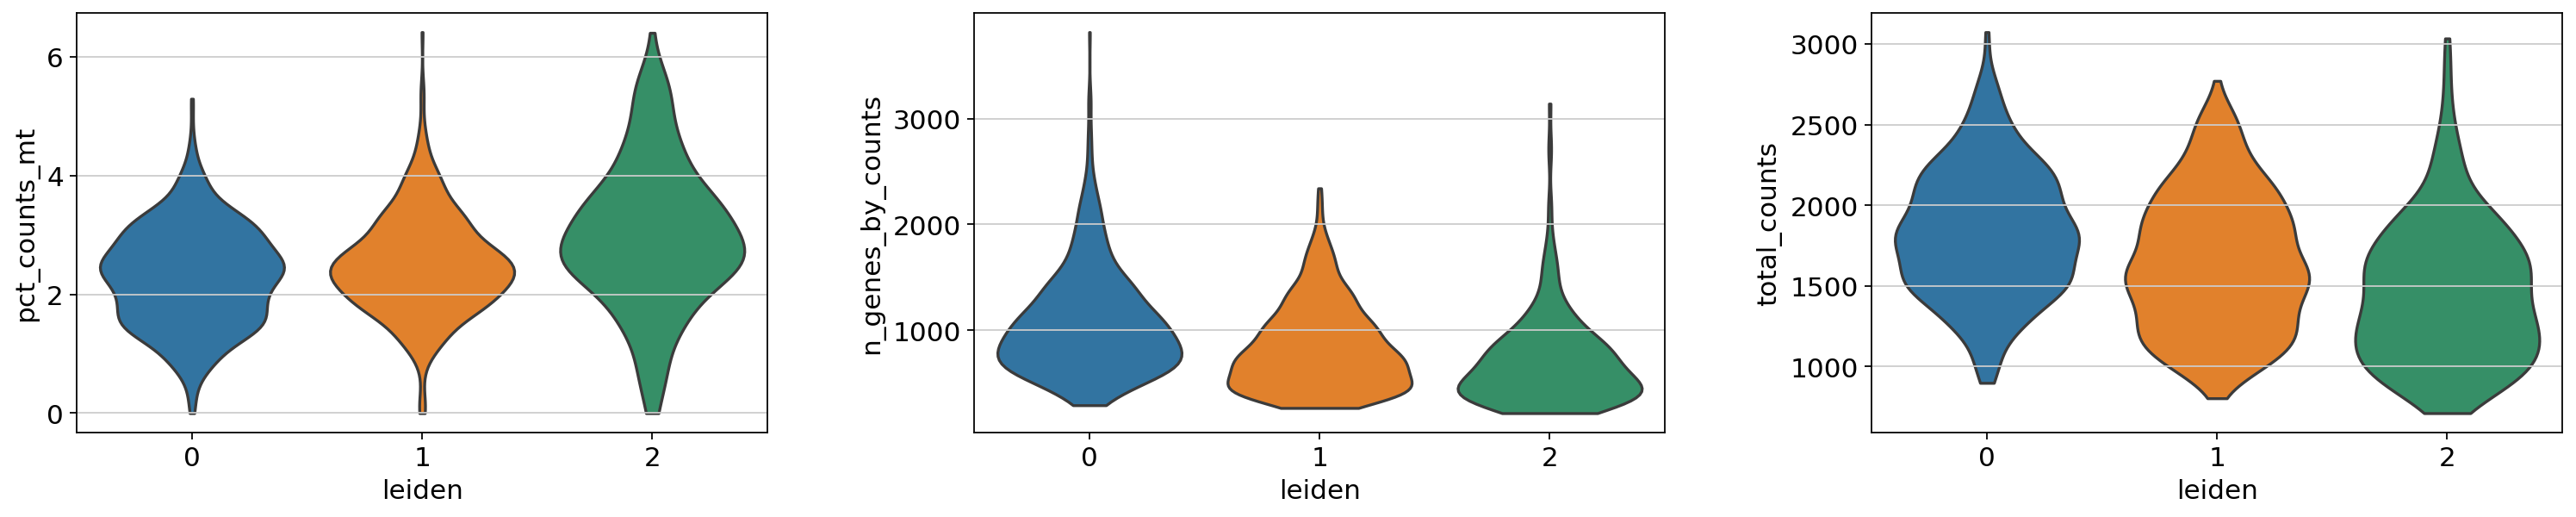

In [28]:
sc.set_figure_params(figsize=(6, 4))

sc.pl.violin(adata, ['pct_counts_mt', 'n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, groupby='leiden', size=0)

In [29]:
# for conveniences, we here rename the sub-clusters as Fib1 to Fib10
adata.obs['sub_clusters'] = adata.obs['leiden']
adata.obs['sub_clusters'] = adata.obs['sub_clusters'].str.replace(r'\b0\b', 'Mac1', regex=True)
adata.obs['sub_clusters'] = adata.obs['sub_clusters'].str.replace(r'\b1\b', 'Mac2', regex=True)
adata.obs['sub_clusters'] = adata.obs['sub_clusters'].str.replace(r'\b2\b', 'Mac3', regex=True)

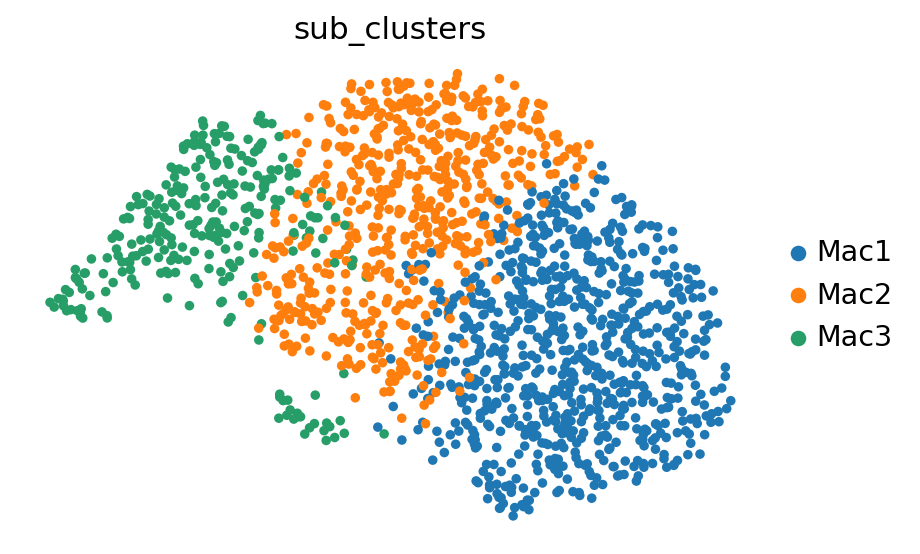

In [30]:
sc.pl.umap(adata, color=['sub_clusters'], frameon=False)

In [31]:
# find marker genes
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, 'sub_clusters', method='wilcoxon')
result = adata.uns['rank_genes_groups']

In [32]:
# output markers
df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)
logfoldchanges = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']).head(200)
pvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals']).head(200)

# Extract marker genes, log fold changes, and p-values
results = []
for cluster in adata.uns['rank_genes_groups']['names'].dtype.names:
    cluster_marker_genes = adata.uns['rank_genes_groups']['names'][cluster][:200]
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][cluster][:200]
    pvals = adata.uns['rank_genes_groups']['pvals'][cluster][:200]
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][cluster][:200]
    
    for gene, logfc, pval, pval_adj in zip(cluster_marker_genes, logfoldchanges, pvals, pvals_adj):
        results.append({
            'gene': gene,
            'log fold change': logfc,
            'p-value': pval,
            'adjusted p-value': pval_adj,
            'cluster': cluster
        })
        
# Convert to DataFrame
markers_df = pd.DataFrame(results)

# Save to CSV
markers_df.to_csv(f'{out_dir}/top_200_marker_genes.csv', index=False)

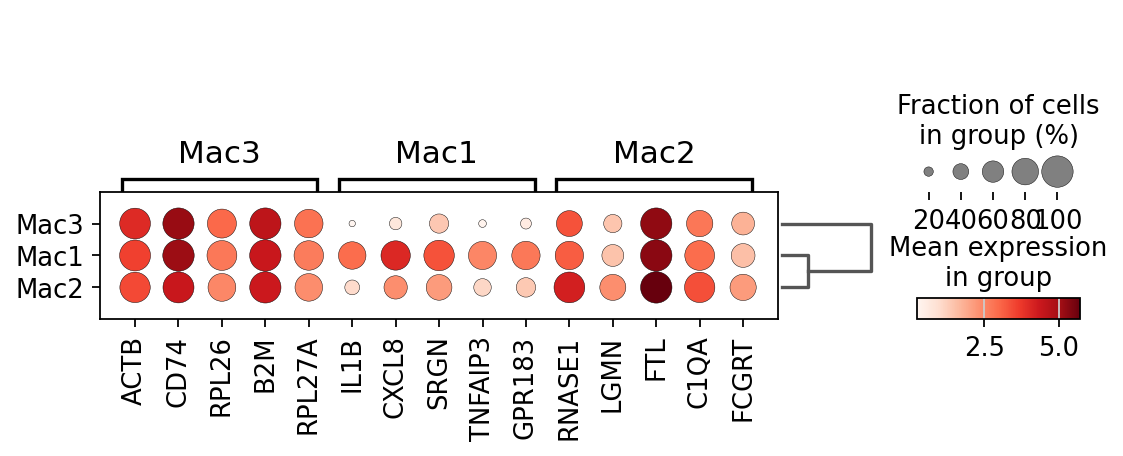

In [33]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5)

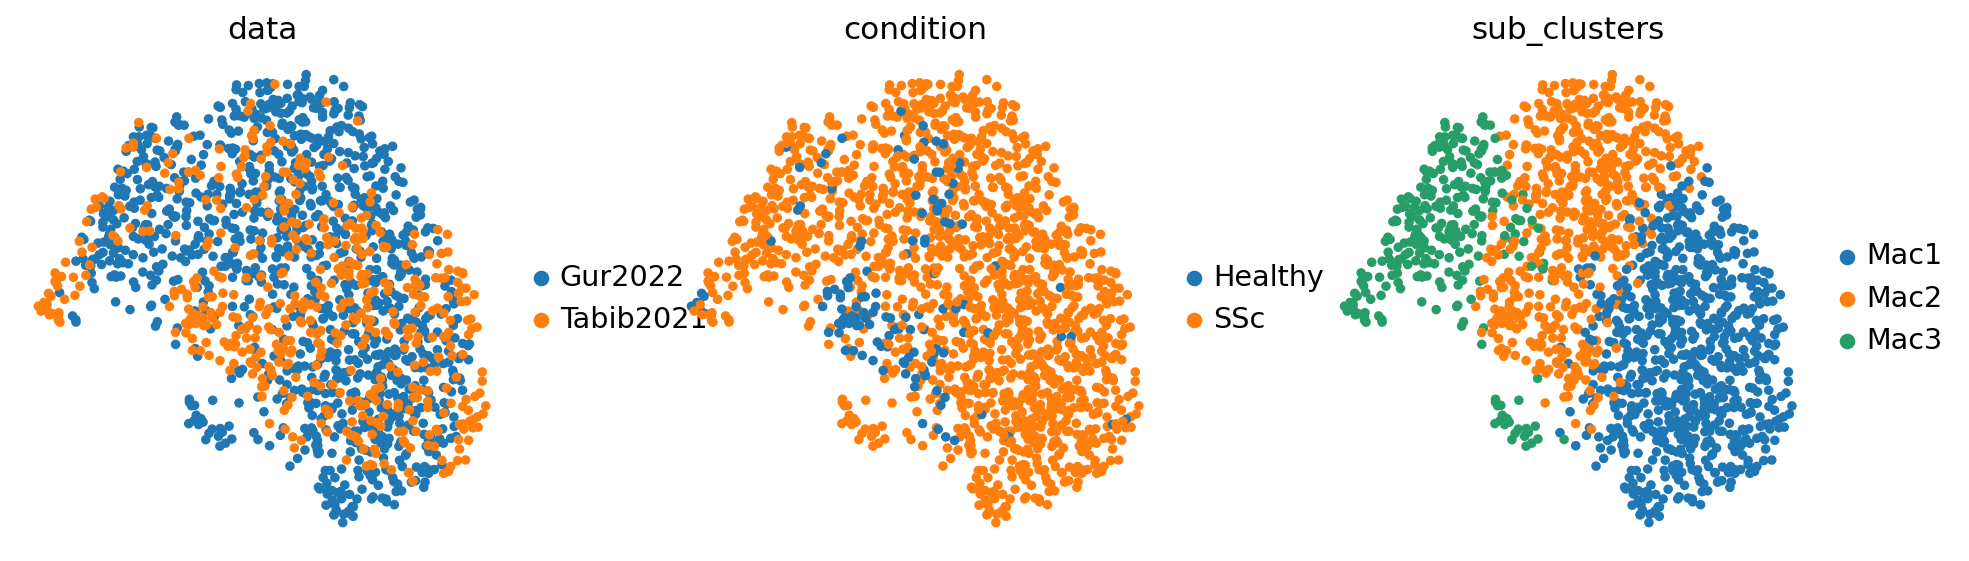

In [34]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.umap(adata, color=['data', 'condition', 'sub_clusters'], frameon=False, ncols=3)

In [35]:
# we can compute the cell-type composition between control and SSc
df_prop = pd.crosstab(adata.obs['patient_id'],adata.obs['sub_clusters'], normalize='index').reset_index()
df_obs = adata.obs[['patient_id', 'condition']].drop_duplicates()
df_prop = pd.melt(df_prop, id_vars=['patient_id'], value_name='proportion')
df = df_prop.merge(df_obs)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mac2_Healthy vs. Mac2_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:2.661e-02 U_stat=3.800e+01
Mac1_Healthy vs. Mac1_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:9.524e-03 U_stat=0.000e+00
Mac3_Healthy vs. Mac3_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:6.749e-01 U_stat=1.500e+01


(<Axes: xlabel='sub_clusters', ylabel='proportion'>,
  <statannotations.Annotation.Annotation at 0x7fadde73fdf0>])

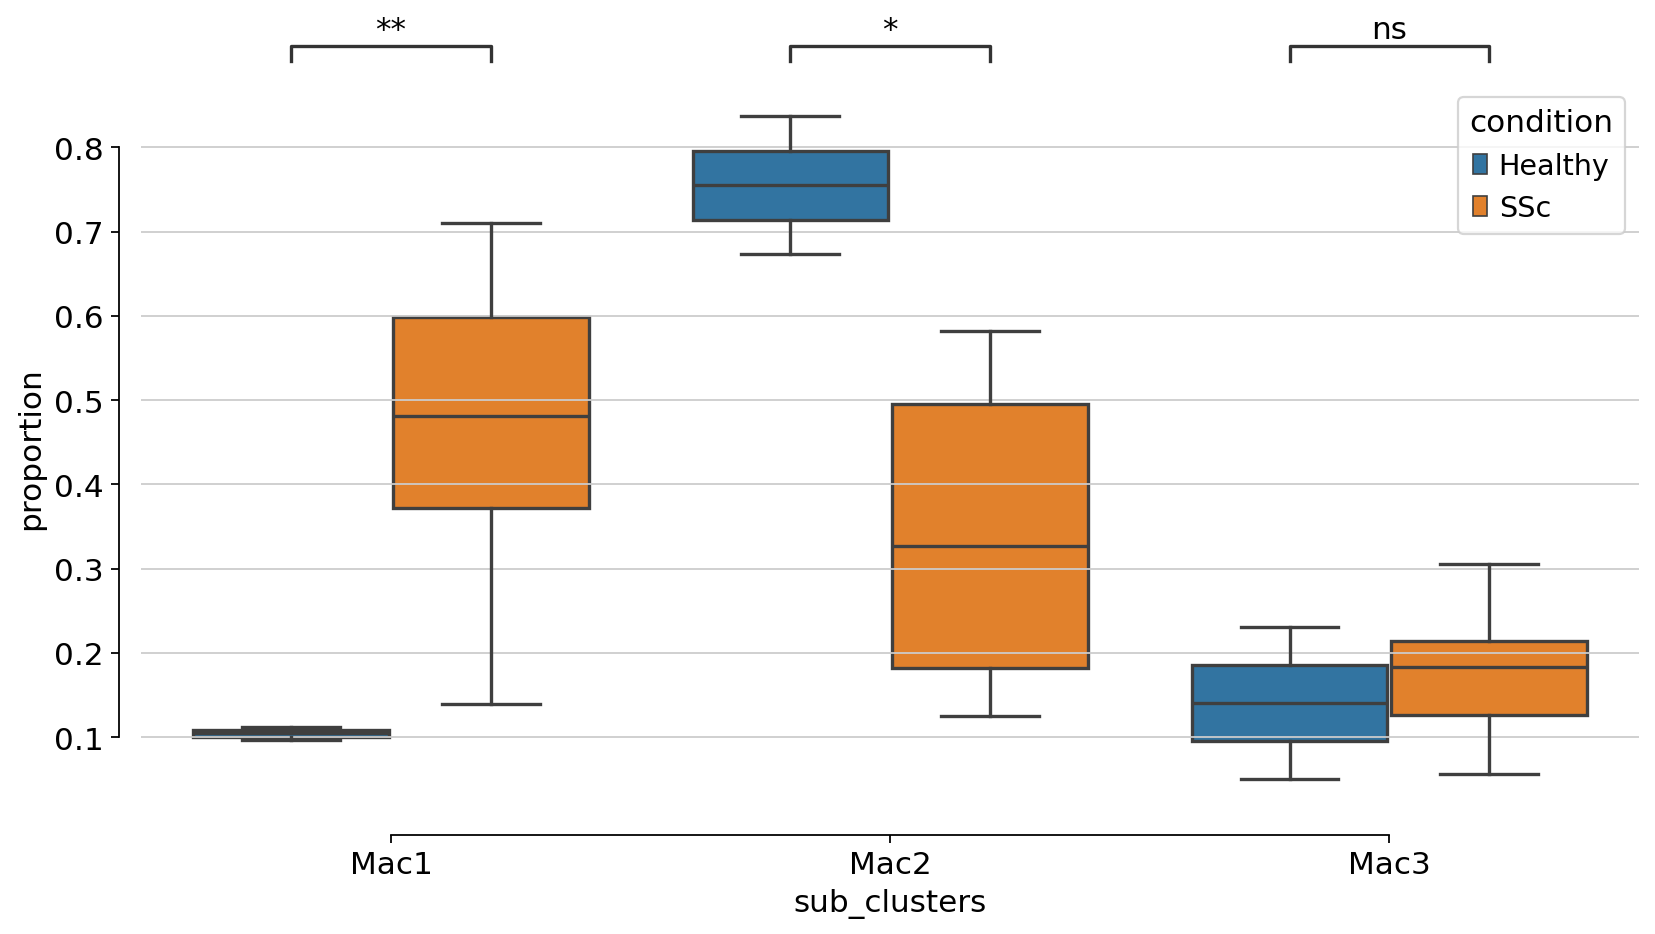

In [36]:
# visualize cell type proportion
sc.set_figure_params(figsize=(12, 6))
ax = sns.boxplot(data=df, 
                 x='sub_clusters', y='proportion', 
                 hue="condition", 
                 showfliers = False)
sns.despine(offset=10, trim=True, ax=ax)

pairs=[(('Mac1', "Healthy"), ('Mac1', "SSc")),
      (('Mac2', "Healthy"), ('Mac2', "SSc")),
      (('Mac3', "Healthy"), ('Mac3', "SSc"))]

annotator = Annotator(ax, pairs, data=df, x='sub_clusters', y='proportion', hue='condition')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [37]:
adata.write_h5ad(f'{out_dir}/macrophages.h5ad')

In [3]:
adata = sc.read_h5ad(f'{out_dir}/macrophages.h5ad')

# we can compute the cell-type composition between control and SSc
df_prop = pd.crosstab(adata.obs['patient_id'],adata.obs['sub_clusters'], normalize='index').reset_index()
df_obs = adata.obs[['patient_id', 'condition']].drop_duplicates()
df_prop = pd.melt(df_prop, id_vars=['patient_id'], value_name='proportion')
df = df_prop.merge(df_obs)

df.to_csv(f'{out_dir}/macrophages_prop_in_patient.csv')